In [33]:
%matplotlib inline
import obspy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from future.builtins import *  # NOQA
from datetime import timedelta
from obspy.core import read
from obspy.core.utcdatetime import UTCDateTime
from obspy.core.inventory import read_inventory
import numpy as np
from obspy.clients.fdsn.client import Client



plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['font.size'] = 12
SECONDS_PER_DAY=3600.*24

In [ ]:

# Load the CSV file
df = pd.read_csv("/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Nakamura_MQCatalog.levent.1008 16.21.csv")

# Print the first complete row
print(df.iloc[10])

# Print the column names
print(df.columns)

In [24]:
def linear_interpolation(trace,interpolation_limit=1):
    """Snippet to interpolate missing data.  

    The SHZ traces have missing data samples 3-4 times every 32 samples. 
    Providing the seed data with these missing data would mean using very 
    large files. Instead, we provide the data with -1 replacing the gaps. 
    To change the files to interpolate across the gaps, use this simple method to 
    replace the -1 values. The trace is modified, and a mask is applied at 
    the end if necessary. 

    :type stream: :class:`~obspy.core.Trace` 
    :param trace: A data trace
    :type interpolation_limit: int 
    :param interpolation_limit: Limit for interpolation. Defaults to 1. For
      more information read the options for the `~pandas.Series.interpolate`
      method. 

    :return: original_mask :class:`~numpy.ndarray` or class:`~numpy.bool_`
       Returns the original mask, before any interpolation is made. 

    """

    trace.data = np.ma.masked_where(trace.data == -1, trace.data)
    original_mask = np.ma.getmask(trace.data)
    data_series = pd.Series(trace.data)
    # data_series.replace(-1.0, pd.NA, inplace=True)
    data_series.interpolate(method='linear', axis=0, limit=interpolation_limit, inplace=True, limit_direction=None, limit_area='inside', downcast=None)
    data_series.fillna(-1.0, inplace=True)
    trace.data=data_series.to_numpy(dtype=int) 
    trace.data = np.ma.masked_where(trace.data == -1, trace.data)
    return original_mask

KO‐SMQ‐12,1973,257,04:31:37,71 ± 3.6,651 ± 106,>5.0,>1.1 × 10^10,>1.9 × 10^14,>3.4,>4.7,S15

In [55]:
inventory = client.get_stations(network="XA", station="*", location="*", channel="SHZ", starttime=t1, endtime=t2, level="response")
print(inventory)

Inventory created at 2025-09-23T10:07:04.514100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=1976-03-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			XA
		Stations (4):
			XA.S12 (ALSEP 12, Oceanus Procellarum, Moon)
			XA.S14 (ALSEP 14, Fra Mauro, Moon)
			XA.S15 (ALSEP 15, Hadley Rille, Moon)
			XA.S16 (ALSEP 16, Descartes, Moon)
		Channels (4):
			XA.S12..SHZ, XA.S14..SHZ, XA.S15..SHZ, XA.S16..SHZ


1 Trace(s) in Stream:
XA.S14..SHZ | 1976-03-06T10:10:00.009070Z - 1976-03-06T10:44:59.990202Z | 53.0 Hz, 111300 samples


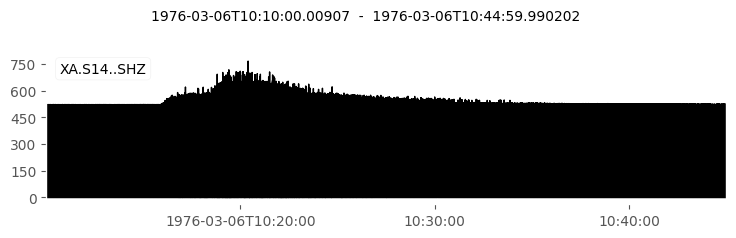

/var/folders/_b/zk3mw_fs0bz5l7wcb96c8x_h0000gr/T/ipykernel_24824/2006576976.py:27: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  data_series.interpolate(method='linear', axis=0, limit=interpolation_limit, inplace=True, limit_direction=None, limit_area='inside', downcast=None)


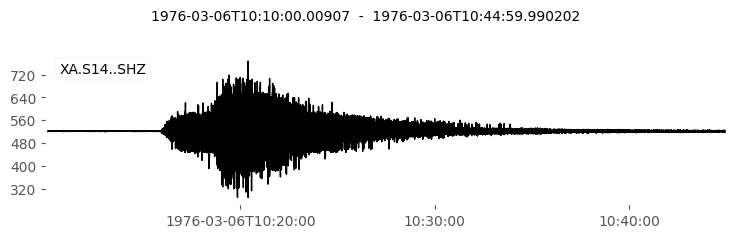

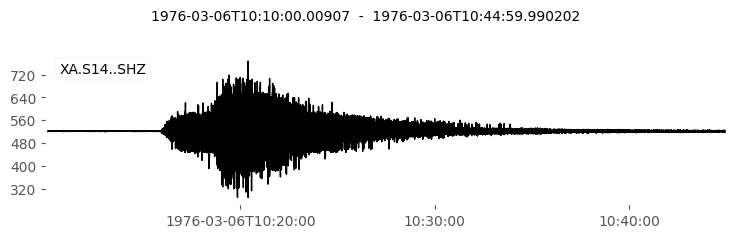

In [113]:
client = Client("IRIS")
t1 = UTCDateTime("1976-03-06T10:10:00.0")
t2 = UTCDateTime("1976-03-06T10:45:00.0")
st = client.get_waveforms(network="XA", station="S14", location="*", channel="SHZ", starttime=t1, endtime=t2)
print(st)
st.plot()

st_interpolated = st.copy()
for tr in st_interpolated:
    original_mask = linear_interpolation(tr,interpolation_limit=1)
st_interpolated.plot()

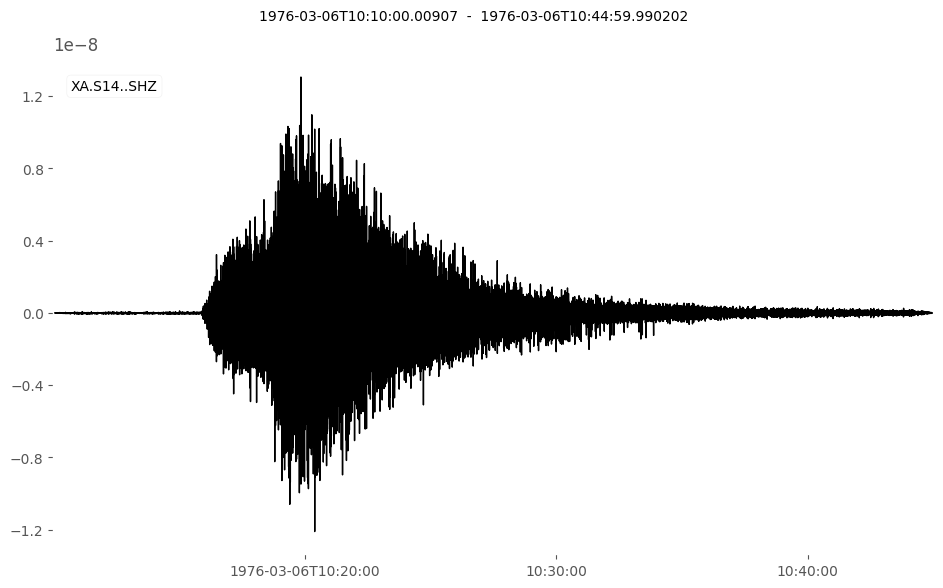

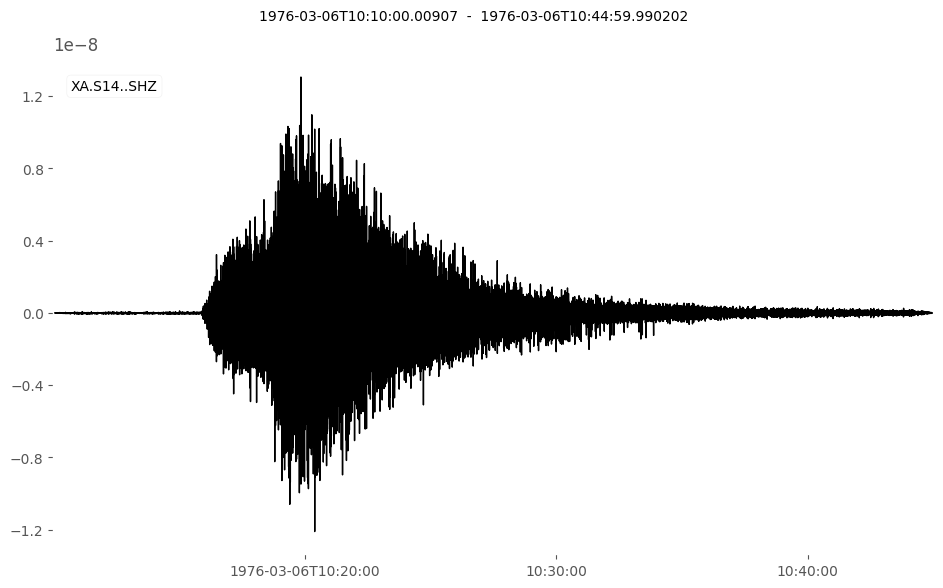

In [114]:
st_predetrended = st_interpolated.copy()
st_predetrended.attach_response(inventory)
st_predetrended.remove_response(inventory=inventory, pre_filt=(0.1, 1, 11, 13), output="DISP", water_level=0)
#st_interpolated.filter("bandpass", freqmin=0.01, freqmax=10, corners=4, zerophase=True)

st_predetrended.plot(equal_scale=False,size=(1000,600),method='full')

In [49]:
def view_Apollo(stream=None,starttime= UTCDateTime('1976-03-06T10:05:00.0'),endtime = UTCDateTime('1976-03-06T10:45:00.0'),
  network='XA',station='S15',channel='SHZ',location='*',plot_seismogram=True,plot_response=False):
    
    client = Client("IRIS")

    # get the response file (wildcards allowed)
    inv = client.get_stations(starttime=starttime, endtime=endtime,
        network=network, sta=station, loc=location, channel=channel,
        level="response")

    if stream is None:
        stream = client.get_waveforms(network=network, station=station, channel=channel, location=location, starttime=starttime, endtime=endtime)

    else:
        stream.trim(starttime=starttime,endtime=endtime)
        
    
    for tr in stream:
        # interpolate across the gaps of one sample 
        linear_interpolation(tr,interpolation_limit=1)
    stream.merge()
    
    for tr in stream:
        # optionally interpolate across any gap 
        # for removing the instrument response from a seimogram, 
        # it is useful to get a mask, then interpolate across the gaps, 
        # then mask the trace again. 
        if tr.stats.channel in ['MH1', 'MH2', 'MHZ']:

            # add linear interpolation but keep the original mask
            original_mask = linear_interpolation(tr,interpolation_limit=None)
            # remove the instrument response
            pre_filt = [0.1,0.3,0.9,1.1]
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                       water_level=None, plot=plot_response)
            if plot_response:
                plt.show()
            # apply the mask back to the trace 
            tr.data = np.ma.masked_array(tr, mask=original_mask)

        elif tr.stats.channel in ['SHZ']:

            # add linear interpolation but keep the original mask
            original_mask = linear_interpolation(tr,interpolation_limit=None)
            # remove the instrument response
            pre_filt = [1,2,11,13] 
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                       water_level=None, plot=plot_response)
            if plot_response:
                plt.show()
            
            # apply the mask back to the trace 
            tr.data = np.ma.masked_array(tr, mask=original_mask)

    if plot_seismogram:
        stream.plot(equal_scale=False,size=(1000,600),method='full')
    
view_Apollo()

NameError: name 'linear_interpolation' is not defined

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


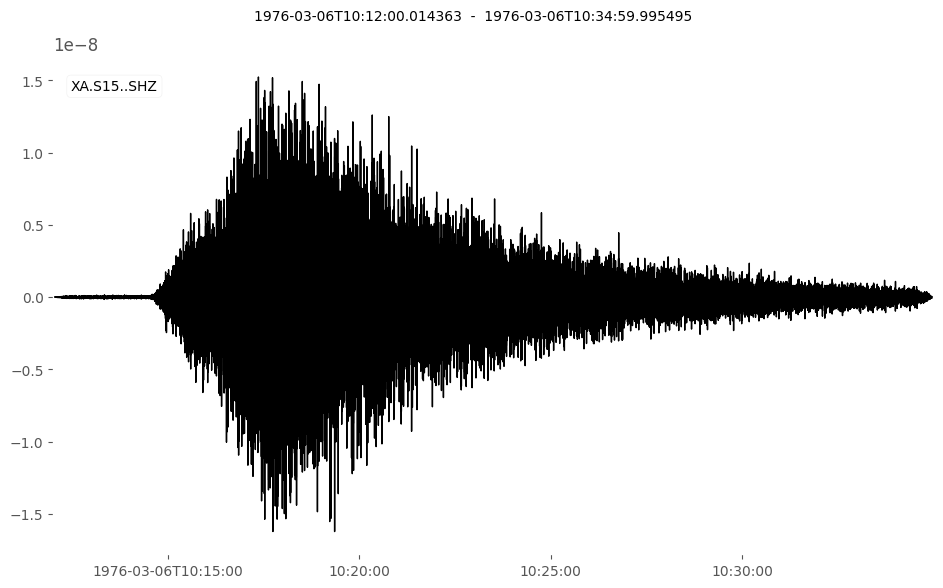

1 Trace(s) in Stream:
XA.S15..SHZ | 1976-03-06T10:12:00.014363Z - 1976-03-06T10:34:59.995495Z | 53.0 Hz, 73140 samples (masked)


In [90]:
from heterogeneities.io import view_apollo
starttime = UTCDateTime("1976-03-06T10:12:00")
endtime   = UTCDateTime("1976-03-06T10:35:00")
network   = "XA"
station   = "S15"
channel   = "SHZ"
location  = "*"

trace = view_apollo(stream=None,
        starttime=starttime,
        endtime=endtime,
        network=network,
        station=station,
        channel=channel,
        location=location,
        plot_seismogram=True,
        plot_response=False,
)

print(trace)

In [88]:
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# --- safer spectrogram helper: replace NaNs in data before specgram ---
def compute_spectrogram(trace, db_limits):
    fs = trace.stats.sampling_rate
    nfft = int(fs * window_sec)
    noverlap = int(nfft * 0.8)

    # NaN-safe data for spectrogram computation
    x = np.asarray(trace.data, dtype=float)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    Pxx, freqs, bins = plt.mlab.specgram(x, NFFT=nfft, Fs=fs, noverlap=noverlap)

    dB = 10 * np.log10(np.maximum(Pxx, 1e-30))  # avoid log10(0)
    dB = np.clip(dB, db_limits[0], db_limits[1])

    # Vectorized time axis for imshow extent
    t0_num = mdates.date2num(trace.stats.starttime.datetime)
    time_bins = t0_num + bins / 86400.0  # seconds -> days
    extent = [time_bins[0], time_bins[-1], freqs[0], freqs[-1]]

    return dB, extent


def plot_single_trace(trace, title, db_limits, y_min_limit=0.01, y_max_limit=20.0, show_waveform=True):
    dB, extent = compute_spectrogram(trace, db_limits)

    if show_waveform:
        fig, (ax_s, ax_w) = plt.subplots(
            2, 1, sharex=True, figsize=(14, 7), gridspec_kw={"height_ratios": [3, 1]}
        )
    else:
        fig, ax_s = plt.subplots(1, 1, figsize=(14, 5))

    # --- spectrogram (linear freq axis) ---
    im = ax_s.imshow(dB, aspect="auto", extent=extent, origin="lower", cmap="inferno")
    ax_s.set_ylim(y_min_limit, y_max_limit)
    ax_s.set_ylabel("Frequency (Hz)")
    cbar = fig.colorbar(im, ax=ax_s, pad=0.01)
    cbar.set_label("Power (dB)")

    # --- waveform (robust time axis) ---
    if show_waveform:
        n = trace.stats.npts
        fs = trace.stats.sampling_rate
        t0_num = mdates.date2num(trace.stats.starttime.datetime)
        t_num = t0_num + (np.arange(n) / fs) / 86400.0  # days

        y = np.asarray(trace.data, dtype=float)
        mask = np.isfinite(y)  # drop NaN/inf if any

        ax_w.plot_date(t_num[mask], y[mask], "-", lw=0.6)
        ax_w.set_ylabel("Amplitude")
        ax_w.set_xlabel("Time (UTC)")
        ax_w.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
        fig.autofmt_xdate()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


/var/folders/_b/zk3mw_fs0bz5l7wcb96c8x_h0000gr/T/ipykernel_47883/3149420503.py:56: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax_w.plot_date(t_num[mask], y[mask], "-", lw=0.6)


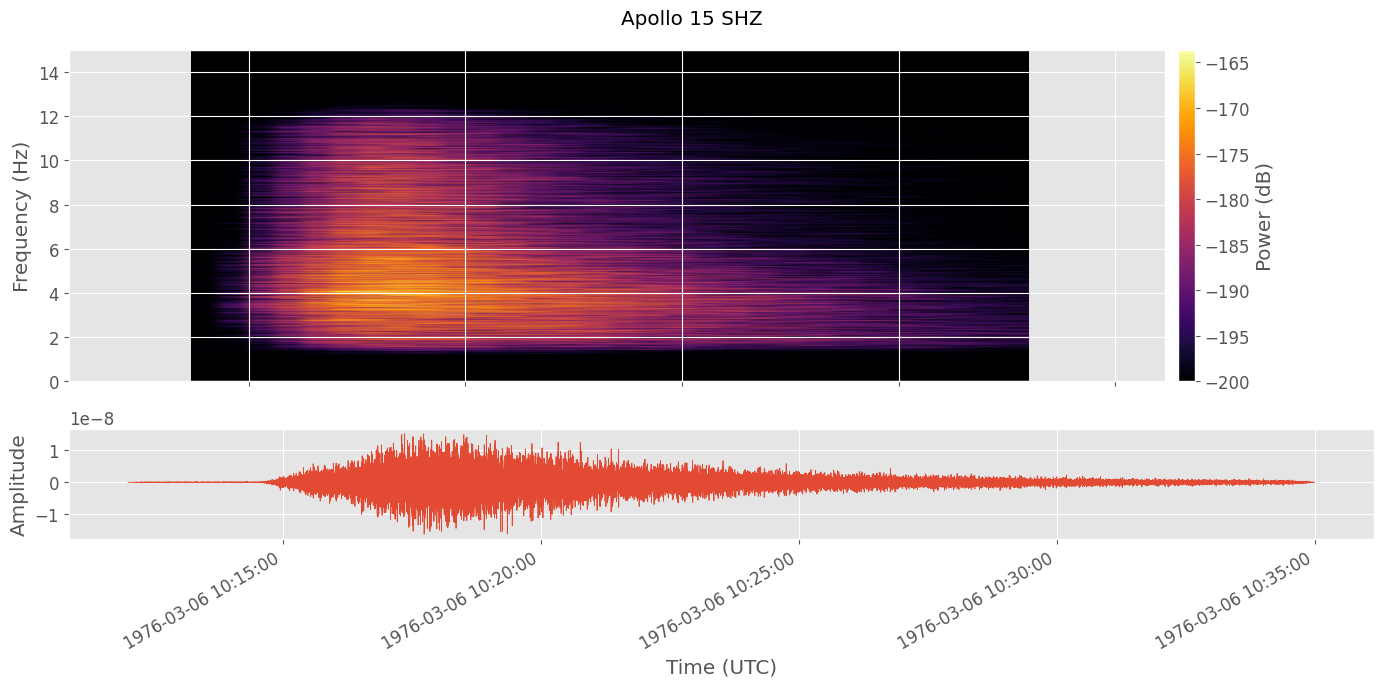

In [116]:
st = trace[0].copy()
plot_single_trace(
    st,
    title="Apollo 15 SHZ",
    db_limits=(-200, 100),  # pick the clipping you want
    y_min_limit=0,
    y_max_limit=15.0,
    show_waveform=True,      # set False if you only want the spectrogram
)
